In [1]:
import sys
sys.path.insert(0, "../..")

In [2]:
def set_size(width = "thesis", fraction=1, subplots=(1, 1)):
    if width == 'thesis':
        width_pt = 426.79135
    elif width == 'beamer':
        width_pt = 307.28987
    else:
        width_pt = width

    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    golden_ratio = (5**0.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    fig_dim = (fig_width_in, fig_height_in)

    return fig_dim

In [3]:
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('seaborn')

from os import listdir
from os.path import isfile, join

from module.base.network import Network
from module.simulation.meanfield import MeanField
import module.components.CONST as CONST
from module.simulation.set_meanfield2 import SetMeanField2
from module.simulation.masterequation import MasterEquation
from module.components.lawrence_dist import LawrenceDist
from module.components.discrete_gaussian1D import DiscreteGaussian1D

/tmp/ipykernel_289/3736232305.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


# Single Electron Transistor

## IV-curve

In [4]:
N = 200
Us = np.linspace(-0.1, 0.1, N)
U_gate = 0.05

Is_me = np.zeros(N)
probs_me = np.zeros((N, 40))
phase_space_me = None
for i, U in enumerate(Us):
    set = MasterEquation(U, U_gate)
    probs = set.solve(N = 2000)
    Is_me[i] = set.expected_current(probs)
    probs_me[i] = probs
    phase_space_me = set.phase_space
    net = Network(1, 1, 1, [[0,0,0], [0,0,0]])

mf = MeanField(net)
Is_mf = np.zeros(N)
mean_mf = np.zeros(N)
for i, U in enumerate(Us):
    net.set_voltage_config([U, 0], U_gate)
    state = mf.numeric_integration_solve(N = 7)
    Is_mf[i] = -mf.calc_expected_electrode_rates(state, 1) * CONST.electron_charge
    mean_mf[i] = state[0]
    
Is_mf2 = np.zeros(N)
mean_mf2 = np.zeros(N)
var_mf2  = np.zeros(N)
for i, U in enumerate(Us):
    mf2 = SetMeanField2(U, U_gate)
    mean, var = mf2.solve(N = 150, dt = 0.01)
    Is_mf2[i] = mf2.calc_expected_output_current(mean, var)
    mean_mf2[i] = mean
    var_mf2[i] = var

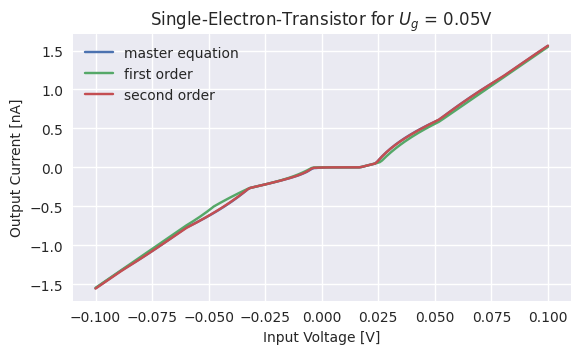

In [5]:
plt.figure(figsize = set_size(fraction = 1))
plt.plot(Us, Is_me, label = "master equation")
plt.plot(Us, Is_mf, label = "first order")
plt.plot(Us, Is_mf2, label = "second order")
plt.xlabel("Input Voltage [V]")
plt.ylabel("Output Current [nA]")
plt.title("Single-Electron-Transistor for $U_{g}$ = "+"{:3.2f}".format(U_gate)+"V")
plt.legend()
plt.tight_layout()
plt.savefig("../../output/set"+str(U_gate)+".pdf")

## Mean comparison

In [6]:
me_means = np.sum(phase_space_me * probs_me, axis = -1)
me_var = np.sum(phase_space_me ** 2 * probs_me, axis = -1) - me_means **2
me_std = np.sqrt(me_var)

std_mf2 = np.sqrt(var_mf2)

decimals = mean_mf - np.floor(mean_mf)
std_mf = np.sqrt(decimals * (1 - decimals))

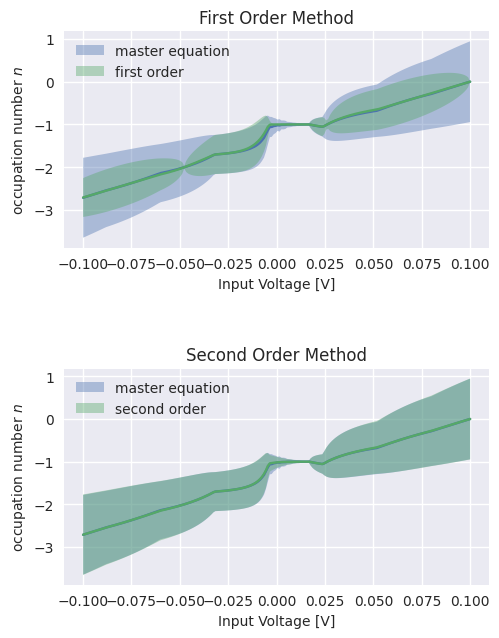

In [7]:
fig, axs = plt.subplots(2, 1, figsize = set_size(subplots=(2,1)))

axs[0].plot(Us, me_means)
axs[0].fill_between(Us, me_means-me_std, me_means + me_std, alpha = 0.4, label = "master equation")
axs[0].plot(Us, mean_mf)
axs[0].fill_between(Us, mean_mf-std_mf, mean_mf + std_mf, alpha = 0.4, label = "first order")
axs[0].set_xlabel("Input Voltage [V]")
axs[0].set_ylabel("occupation number $n$")
axs[0].legend(loc = "upper left")
axs[0].set_title("First Order Method")

axs[1].plot(Us, me_means)
axs[1].fill_between(Us, me_means-me_std, me_means + me_std, alpha = 0.4, label = "master equation")
axs[1].plot(Us, mean_mf2)
axs[1].fill_between(Us, mean_mf2-std_mf2, mean_mf2 + std_mf2, alpha = 0.4, label = "second order")
axs[1].set_xlabel("Input Voltage [V]")
axs[1].set_ylabel("occupation number $n$")
axs[1].legend(loc = "upper left")
axs[1].set_title("Second Order Method")

fig.tight_layout(pad = 4)
plt.savefig("../../output/set_state"+str(U_gate)+".pdf")

## Diamonds

In [4]:
net = Network(1,1,1,[[0,0,0],[0,0,0]])
mf = MeanField(net)

In [5]:
N_gate = 150
Us_gate = np.linspace(-0.1, 0.1, N_gate)

N_input = N_gate
Us_input = np.linspace(-0.1, 0.1, N_input)

In [12]:
I_output_mf = np.zeros((N_gate, N_input))
for i, U_gate in enumerate(Us_gate):
    for j, U_input in enumerate(Us_input):
        net.set_voltage_config([U_input, 0], U_gate)
        state = mf.numeric_integration_solve(N = 5)
        I_output_mf[i, j] = -mf.calc_expected_electrode_rates(state, 1) * CONST.electron_charge


I_output_mf2 = np.zeros((N_gate, N_input))
for i, U_gate in enumerate(Us_gate):
    for j, U_input in enumerate(Us_input):
        mf2 = SetMeanField2(U_input, U_gate)
        mean, var = mf2.solve(N = 150, dt = 0.01)
        I_output_mf2[i, j] = mf2.calc_expected_output_current(mean, var)


I_output_me = np.zeros((N_gate, N_input))
for i, U_gate in enumerate(Us_gate):
    for j, U_input in enumerate(Us_input):
        me = MasterEquation(U_input, U_gate)
        probs = me.solve(N = 2000)
        I_output_me[i, j] = me.expected_current(probs)

KeyboardInterrupt: 

In [6]:
#np.savetxt("../../data/diamonds/set_diamond_me.csv", I_output_me)
#np.savetxt("../../data/diamonds/set_diamond_mf.csv", I_output_mf)
#np.savetxt("../../data/diamonds/set_diamond_mf2.csv", I_output_mf2)

I_output_me = np.loadtxt("../../data/diamonds/set_diamond_me.csv")
I_output_mf = np.loadtxt("../../data/diamonds/set_diamond_mf.csv")
I_output_mf2 = np.loadtxt("../../data/diamonds/set_diamond_mf2.csv")

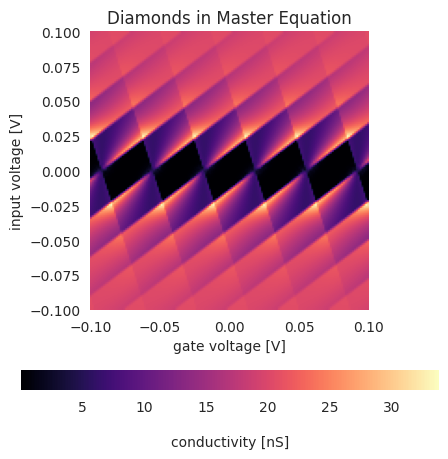

In [13]:
grad_output = np.gradient(I_output_me, 0.2/N_input, axis = 1)
img = np.swapaxes(grad_output, 0, 1)
img = np.flip(img, axis = 0)

plt.figure(figsize = (set_size(fraction = 0.8)[0], set_size(fraction = 0.8)[0]))
plt.imshow(img, extent = (Us_gate[0],Us_gate[-1],Us_input[0],Us_input[-1]), cmap = "magma")
plt.grid()
cbar = plt.colorbar(orientation = "horizontal")
cbar.ax.get_xaxis().labelpad = 15
cbar.ax.set_xlabel('conductivity [nS]', rotation = 00)
plt.xlabel("gate voltage [V]")
plt.ylabel("input voltage [V]")
plt.title("Diamonds in Master Equation")
plt.tight_layout()
plt.savefig("../../output/set/set_diamond_me.pdf")

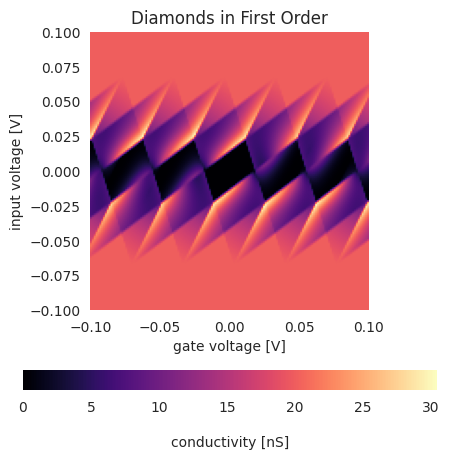

In [75]:
grad_output = np.gradient(I_output_mf, 0.2/N_input, axis = 1)
img = np.swapaxes(grad_output, 0, 1)
img = np.flip(img, axis = 0)

plt.figure(figsize = (set_size(fraction = 0.8)[0], set_size(fraction = 0.8)[0]))
plt.imshow(img, extent = (Us_gate[0],Us_gate[-1],Us_input[0],Us_input[-1]), cmap = "magma")
plt.grid()
cbar = plt.colorbar(orientation = "horizontal")
cbar.ax.get_xaxis().labelpad = 15
cbar.ax.set_xlabel('conductivity [nS]', rotation = 00)
plt.xlabel("gate voltage [V]")
plt.ylabel("input voltage [V]")
plt.title("Diamonds in First Order")
plt.tight_layout()
plt.savefig("../../output/set/set_diamond_mf.pdf")

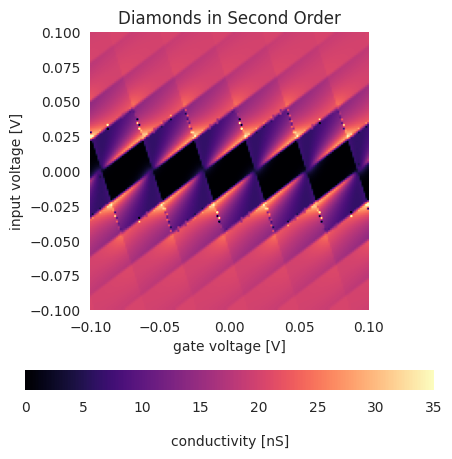

In [72]:
grad_output = np.gradient(I_output_mf2, 0.2/N_input, axis = 1)
img = np.swapaxes(grad_output, 0, 1)
img = np.flip(img, axis = 0)

plt.figure(figsize = (set_size(fraction = 0.8)[0], set_size(fraction = 0.8)[0]))
plt.imshow(img, extent = (Us_gate[0],Us_gate[-1],Us_input[0],Us_input[-1]), vmin = 0, vmax = 35, cmap = "magma")
plt.grid()
cbar = plt.colorbar(orientation = "horizontal")
cbar.ax.get_xaxis().labelpad = 15
cbar.ax.set_xlabel('conductivity [nS]', rotation = 00)
plt.xlabel("gate voltage [V]")
plt.ylabel("input voltage [V]")
plt.title("Diamonds in Second Order")
plt.tight_layout()
plt.savefig("../../output/set/set_diamond_mf2.pdf")

In [51]:
np.arange(0,151,50)

array([  0,  50, 100, 150])

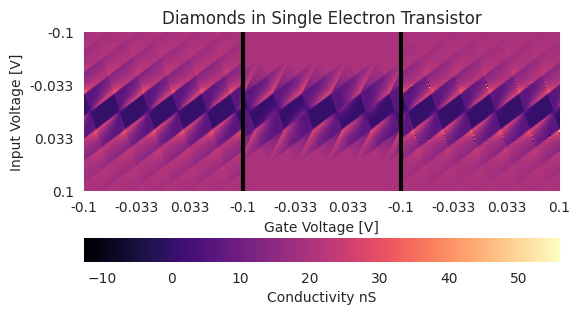

In [59]:
plt.figure(figsize = set_size())


grad_output = np.gradient(I_output_me, 0.2/N_input, axis = 1)
img = np.swapaxes(grad_output, 0, 1)
img0 = np.flip(img, axis = 0)

grad_output = np.gradient(I_output_mf, 0.2/N_input, axis = 1)
img = np.swapaxes(grad_output, 0, 1)
img1 = np.flip(img, axis = 0)

grad_output = np.gradient(I_output_mf2, 0.2/N_input, axis = 1)
img = np.swapaxes(grad_output, 0, 1)
img2 = np.flip(img, axis = 0)

img = np.concatenate((img0,img1,img2), axis = 1)

# plt.imshow(img, extent = (Us_gate[0]*3,Us_gate[-1]*3,Us_input[0],Us_input[-1]), cmap = "magma")
plt.imshow(img, cmap = "magma")
plt.grid()
plt.axvline(150, color = "black", linewidth = 3)
plt.axvline(300, color = "black", linewidth = 3)
cbar = plt.colorbar(orientation = "horizontal")
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_xlabel('Conductivity nS')

plt.yticks(np.arange(0,151,50), np.round(np.linspace(-0.1,0.1, num = 4), 3))
plt.xticks([0,   50,     100,   150,  200,    250,   300,  350,   400, 450],
           [-0.1,-0.033, 0.033, -0.1, -0.033, 0.033, -0.1, -0.033, 0.033, 0.1])
plt.xlabel("Gate Voltage [V]")
plt.ylabel("Input Voltage [V]")
plt.title("Diamonds in Single Electron Transistor")


plt.tight_layout()
plt.savefig("../../output/set/set_diamonds.pdf")

## Distribution comparison

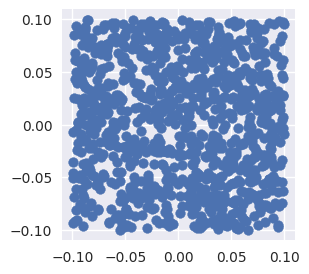

In [9]:
N = 1000
U_input = np.random.uniform(-0.1, 0.1, N)
U_gate = np.random.uniform(-0.1, 0.1, N)

plt.figure(figsize = (3,3))
plt.scatter(U_input, U_gate)

In [10]:
probs_me = np.zeros((N, 40))
probs_mf = np.zeros((N, 40))
probs_mf2 = np.zeros((N, 40))

currents_me = np.zeros(N)
currents_mf = np.zeros(N)
currents_mf2 = np.zeros(N)

std_currents_me = np.zeros(N)
std_currents_mf2 = np.zeros(N)

phase_space = np.arange(-20, 20)

In [11]:
for i in range(N):

    #master equation
    me = MasterEquation(U_input[i], U_gate[i])
    probs_me[i] = me.solve(N = 2000)
    currents_me[i] = me.expected_current(probs_me[i])
    current_squared = me.expected_squared_current(probs_me[i])
    std_currents_me[i] = np.sqrt(current_squared - currents_me[i]**2)
    
    #mf
    net = Network(1, 1, 1, [[0,0,0], [0,0,0]])
    net.set_voltage_config([U_input[i], 0], U_gate[i])
    mf = MeanField(net)
    ldist = LawrenceDist()
    state = mf.numeric_integration_solve(N = 10)
    probs_mf[i] = ldist.calc_prob(state[0])
    currents_mf[i] = -mf.calc_expected_electrode_rates(state, 1) * CONST.electron_charge

    #mf2
    mf2 = SetMeanField2(U_input[i], U_gate[i])
    mean, var = mf2.solve(N = 200, dt = 0.01)
    gaussian = DiscreteGaussian1D()
    probs_mf2[i] = gaussian.calc_prob(mean, var)
    currents_mf2[i] = mf2.calc_expected_output_current(mean, var)
    current_squared = mf2.calc_expected_squared_output_current(mean , var)
    std_currents_mf2[i] = np.sqrt(current_squared - currents_mf2[i] ** 2)

In [12]:
valid = np.where(currents_me > 3e-2)[0] # exclusion of too small currents
N_valid = valid.shape[0]

errs_mf = np.abs((currents_mf - currents_me)/currents_me)[valid]
errs_mf2 = np.abs((currents_mf2 - currents_me)/currents_me)[valid]

In [13]:
print("first order method:")
print("mean err:", np.mean(errs_mf))

print("second order method:")
print("mean err:", np.mean(errs_mf2))

first order method:
mean err: 0.035014885914059095
second order method:
mean err: 0.008658417648892735
